In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input

from keras.layers import Input, BatchNormalization, Activation
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
#from mlxtend.plotting import plot_confusion_matrix
import random
#from imblearn.over_sampling import RandomOverSampler

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 623322218732181153
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1028665379760345464
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3719934887356067142
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5041393823418197696
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:2"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4155553631136597265
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:3"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 887056811589723236
physical_device_desc: "device: XLA_GPU device"
]
[]
2.3.1


## Reading data csv

In [3]:
labelsdf= pd.read_csv("worDwiseLabels/gt.csv")

In [4]:
labelsdf.head()

,File_name,Script,translation,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,word_1.png,Arabic,فروجنا,NaN,NaN,NaN,NaN
1,word_2.png,Arabic,المشوى,NaN,NaN,NaN,NaN
2,word_3.png,Arabic,حلال,NaN,NaN,NaN,NaN
3,word_4.png,Arabic,و,NaN,NaN,NaN,NaN
4,word_5.png,Arabic,طازج,NaN,NaN,NaN,NaN


In [5]:
(labelsdf['Script']).value_counts()

Latin       42629
Korean       4476
Japanese     4108
Arabic       3505
Bangla       3214
Chinese      2702
Symbols      1133
3               1
Name: Script, dtype: int64

Text(0.5, 1.0, 'number of images of each script')

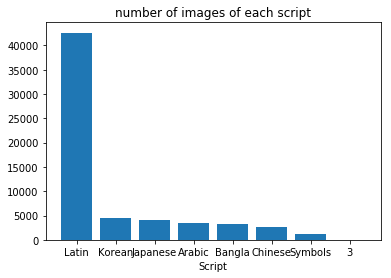

In [6]:
ab=labelsdf['Script'].value_counts()
plt.bar(ab.index,ab)
plt.xlabel('Script')
plt.title('number of images of each script')

## Removing symbols and unnecessary Scripts and nas

In [7]:

labelsdf = labelsdf.dropna(axis=0, subset=['Script'])
labelsdf = labelsdf.dropna(axis=0, subset=['File_name'])
labelsdf=labelsdf[(labelsdf['Script'] !='Symbols')]
labelsdf=labelsdf[(labelsdf['Script'] !='3')]

In [15]:
mergeDF=pd.merge(labelsdf, imageInfoDf, left_on="File_name", right_on="fileName")

In [16]:
mergeDF.describe()

,height,width,ratio,logratio
count,60632.000000,60632.000000,60632.000000,60632.000000
mean,114.723958,263.486014,2.550676,0.721873
std,170.531192,337.704655,1.718678,0.694125
min,6.000000,6.000000,0.053450,-2.929010
25%,37.000000,67.000000,1.383486,0.324606
50%,67.000000,145.000000,2.192627,0.785100
75%,128.000000,316.000000,3.283582,1.188935
max,3869.000000,3918.000000,34.489362,3.540651


In [17]:
ab=labelsdf['Script'].value_counts()
scripts=ab.index

In [18]:
scripts=list(scripts)

## Sample Images

In [37]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,12))
  for n in range(30):
      ax = plt.subplot(6,5,n+1)
      plt.imshow(image_batch[n])
      plt.title("Label: " + str(label_batch[n]))
      plt.axis('off')

In [ ]:
#from skimage import io
import os
import cv2

import random

xSet=[]
ySet=[]

folder = 'wordWise'

for script in scripts:
    indexList=labelsdf.index[labelsdf['Script'] == script].tolist()
    indexList=random.sample(indexList,5)
    Imglist= [labelsdf['File_name'][v] for v in indexList]
    for filename in Imglist:
        img = cv2.imread(os.path.join(folder,filename))
        xSet.append(img)
        ySet.append(script)
        





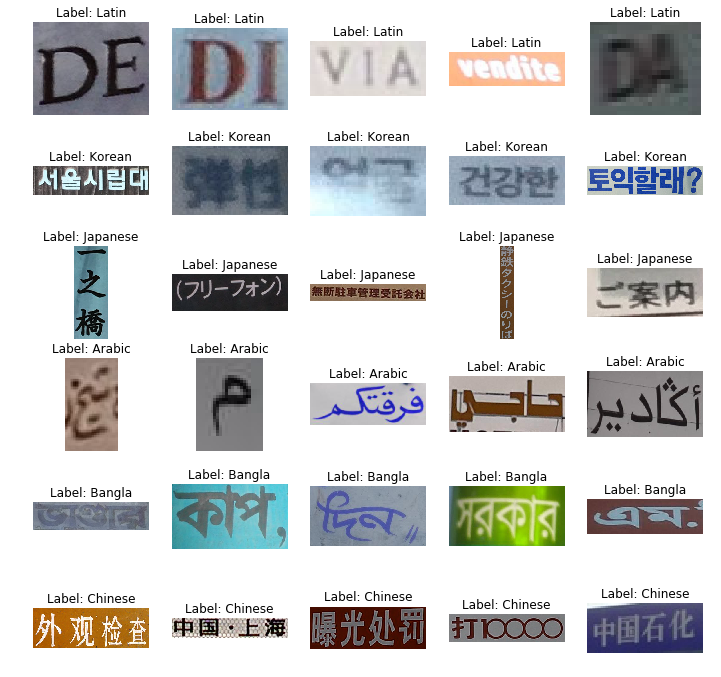

In [38]:
show_batch(xSet, ySet) 

### Image Data analysis

In [9]:
import cv2
import os

imageInfoDf= pd.DataFrame()

name=[]
height=[]
width=[]


def load_images_from_folder(folder):
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            name.append(filename)
            width.append(img.shape[1])
            height.append(img.shape[0])


In [10]:
load_images_from_folder("wordWise")

In [11]:
imageInfoDf['fileName']=name
imageInfoDf['height']=height
imageInfoDf['width']=width

In [12]:
imageInfoDf['ratio']=imageInfoDf['width']/imageInfoDf['height']
imageInfoDf['logratio']=imageInfoDf['ratio'].apply(math.log)

Text(0, 0.5, 'Frequency')

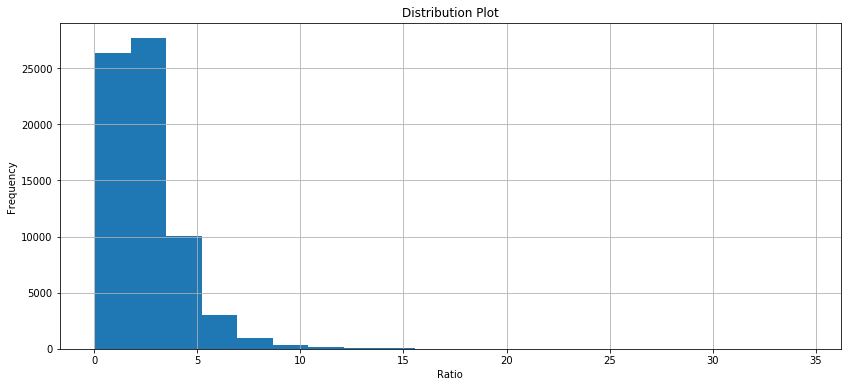

In [47]:
imageInfoDf['ratio'].hist(bins=20, figsize=[14,6])
plt.title('Distribution Plot')
plt.xlabel('Ratio width:height')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

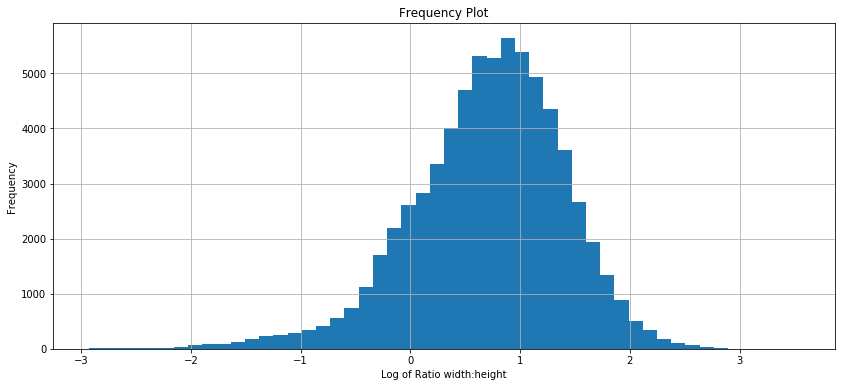

In [49]:
imageInfoDf['logratio'].hist(bins=50, figsize=[14,6])
plt.title('Frequency Plot')
plt.xlabel('Log of Ratio width:height')
plt.ylabel('Frequency')

Text(0, 0.5, 'Density')

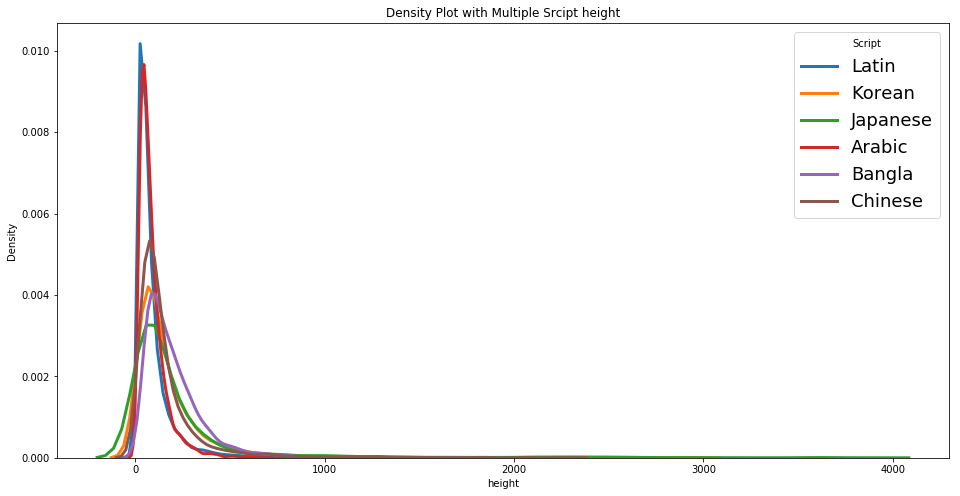

In [27]:
plt.figure(figsize=(16,8))
for script in scripts:
    # Subset to the airline
    subset = mergeDF[mergeDF['Script'] == script]
    sns.distplot(subset['height'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},label = script)

plt.legend(prop={'size': 18}, title = 'Script')
plt.title('Density Plot with Multiple Srcipt height')
plt.xlabel('height')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

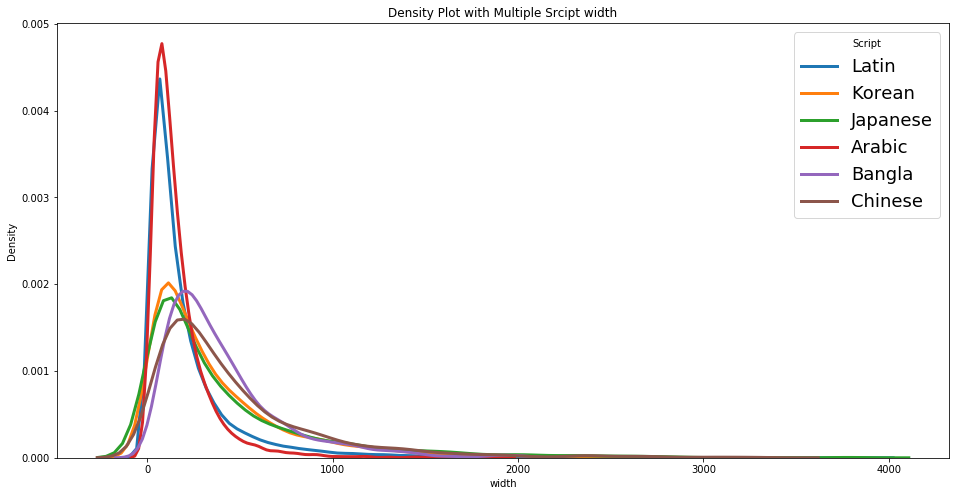

In [29]:
plt.figure(figsize=(16,8))
for script in scripts:
    # Subset to the airline
    subset = mergeDF[mergeDF['Script'] == script]
    sns.distplot(subset['width'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},label = script)

plt.legend(prop={'size': 18}, title = 'Script')
plt.title('Density Plot with Multiple Srcipt width')
plt.xlabel('width')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

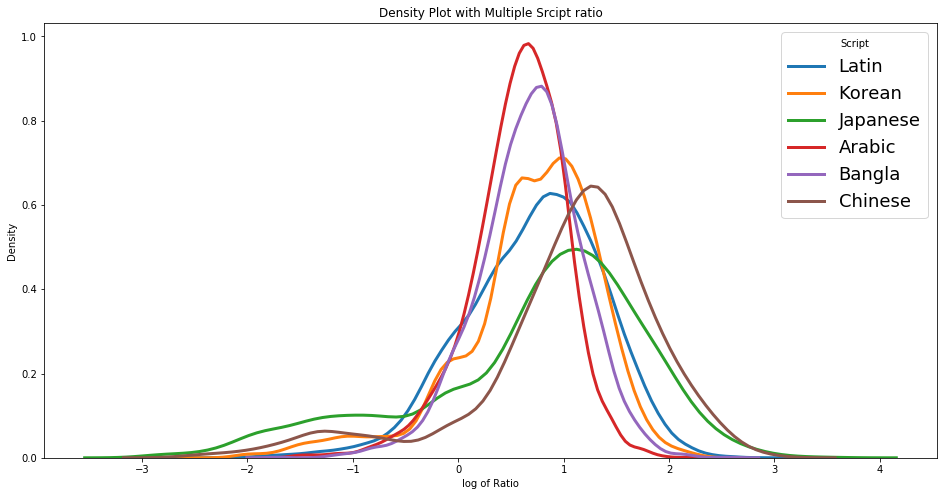

In [25]:
plt.figure(figsize=(16,8))
for script in scripts:
    # Subset to the airline
    subset = mergeDF[mergeDF['Script'] == script]
    sns.distplot(subset['logratio'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},label = script)

plt.legend(prop={'size': 18}, title = 'Script')
plt.title('Density Plot with Multiple Srcipt ratio')
plt.xlabel('log of Ratio')
plt.ylabel('Density')

In [33]:

class_index={0:'Arabic',1:'Bangla', 2:'Chinese', 3:'Japanese', 4:'Korean',5:'Latin'}
#class_index={'Arabic': 0,'Bangla': 1,'Chinese': 2,'Japanese': 3,'Korean': 4,'Latin': 5}


In [34]:
total=labelsdf['Script'].value_counts().sum()

In [35]:
vc=labelsdf['Script'].value_counts()

In [36]:
class_weights={val:total/vc[class_index[val]]for val in class_index}

In [37]:
class_weights

{0: 17.29928673323823,
 1: 18.865588052271313,
 2: 22.440414507772022,
 3: 14.75998052580331,
 4: 13.546470062555853,
 5: 1.4223650566515753}

## Padding Images to a fixed dimention in order to maintain the aspect ratio of the images

In [ ]:
desired_size = 128

directory = 'wordWise_Padded/'

if not os.path.exists(directory):
    os.makedirs(directory)


    for filename in os.listdir('wordWise'):
    
        img = cv2.imread(os.path.join('wordWise',filename))
    
    
        # old_size[0] is in (width, height) format
        old_size = img.shape[:2]

        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        # new_size should be in (width, height) format
        img = cv2.resize(img, (new_size[1], new_size[0])) 

        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)

        color = [0, 0, 0]
        new_im = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

        path = directory + filename
        cv2.imwrite(path, new_im)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        


In [39]:
#from skimage import io
import os
import cv2

import random

xSet=[]
ySet=[]

folder = 'wordWise_Padded'

for script in scripts:
    indexList=labelsdf.index[labelsdf['Script'] == script].tolist()
    indexList=random.sample(indexList,5)
    Imglist= [labelsdf['File_name'][v] for v in indexList]
    for filename in Imglist:
        img = cv2.imread(os.path.join(folder,filename))
        xSet.append(img)
        ySet.append(script)
        

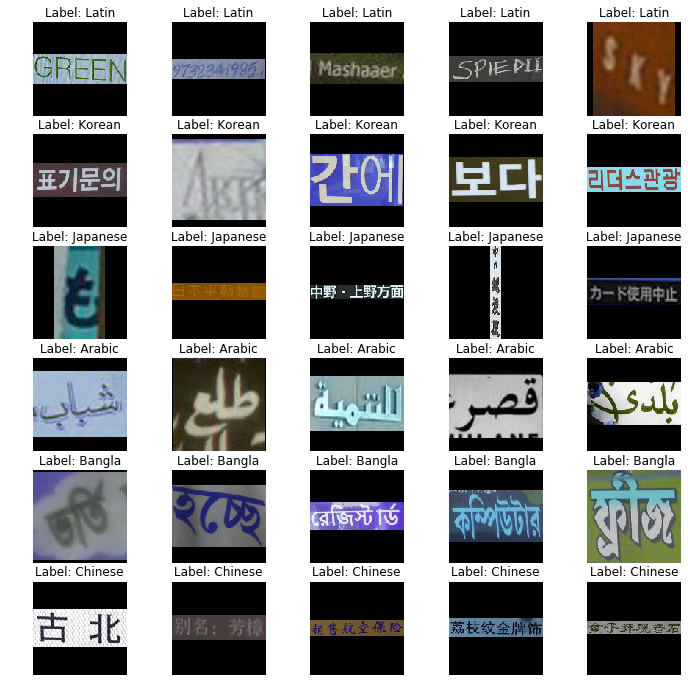

In [40]:
show_batch(xSet, ySet) 